PubCrawl Simulation Developer Notebook

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
plt.style.use(['science','grid'])
import PubCrawlFunctions as PCF

# import custom modules
import Pub

In [29]:
### init the Pubs
# load the Pub CSV
pubsList = np.genfromtxt('Pubs.csv', delimiter=',', dtype=str, skip_header=1)
# init the Pubs 
Pubs = []
for i in range(pubsList.shape[0]):
    pubID = pubsList[i][0]
    openingTime = pubsList[i][1]
    closingTime = pubsList[i][2]
    popularity = pubsList[i][3]
    posX = pubsList[i][4]
    posY = pubsList[i][5]
    # create the Pub
    pub = Pub.Pub(pubID, openingTime, closingTime, popularity, posX, posY)
    Pubs.append(pub)

In [30]:
def showPubMap(Pubs):
    # loop over the Pubs, extract the x and y coordinates and plot them
    x = []
    y = []
    for pub in Pubs:
        x.append(pub.posX)
        y.append(pub.posY)
    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Pub Map')
    plt.show()
    

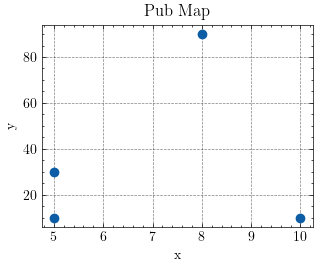

In [31]:
showPubMap(Pubs)

In [32]:
currentTime = 10

# show waiting times for all pubs
for p in Pubs:
    print('Pub ID: ', p.pubID, ' Waiting Time: ', p.getWaitingTime(currentTime))

Pub ID:  1  Waiting Time:  100
Pub ID:  2  Waiting Time:  3
Pub ID:  3  Waiting Time:  93
Pub ID:  4  Waiting Time:  1


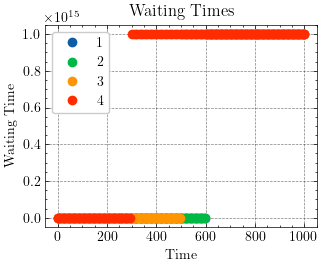

In [33]:
currT = np.linspace(0, 1000, 100)

# evaluate the waiting time for all pubs at different times
for p in Pubs:
    waitingTimes = []
    for t in currT:
        waitingTimes.append(p.getWaitingTime(t))
    plt.plot(currT, waitingTimes, 'o', label=p.pubID)
    plt.xlabel('Time')
    plt.ylabel('Waiting Time')
    plt.title('Waiting Times')
    plt.legend()

# plot wainting times for all pubs in a subplot



# Implementation of the Ant-Colony Optimization

1.) Init the pheromone and visibility matrix


In [34]:
# simulation paramters
tau0 = 1

# simulation counters
time = 0
timeMax = int(60*12)            # 12 hours in minutes - 3pm to 3am 

# population size of ants
popSize = 100

# velocity of an ant
velAnt = 1

In [35]:
# init the pheromone matrix which is a 2D array with the size of the number of pubs
pheromoneMatrix = np.ones((len(Pubs), len(Pubs)))
pheromoneMatrix = pheromoneMatrix * tau0

# init the visibility matrix
visibilityMatrix = np.zeros((len(Pubs), len(Pubs)))


# the visibility matrix is in this case not only the distance between the pubs, but also takes into consideration
# the waiting time at the next pub
# we inititalize the matrix at time = 0

# init the distance matrix D
distanceMatrix = np.zeros((len(Pubs), len(Pubs)))
for i in range(len(Pubs)):
    for j in range(len(Pubs)):
        distanceMatrix[i][j] = PCF.getDistance(Pubs[i], Pubs[j])


In [36]:
# start the simulation, the parameters to be optimized is the total time to visit all pubs

# init the ants at random pubs, that open at time = 0 
initialPubs = []
for p in Pubs:
    if p.openingTime == 0:
        initialPubs.append(p)

print('Number of initial pubs: ', len(initialPubs))
print('Initial pubs: ', initialPubs)


while (time<timeMax):
    # init the ants at random pubs, that open at time = 0
    ants = []
    for i in range(popSize):
        ants.append(PCF.Ant(initialPubs[np.random.randint(len(initialPubs))], velAnt))


Number of initial pubs:  1
Initial pubs:  [<Pub.Pub object at 0x117b94400>]


In [37]:
print('Distance Matrix: ', distanceMatrix)

print('Pheromone Matrix: ', pheromoneMatrix)

print('Waiting vector: ', PCF.getWaitingVector(Pubs, time))

print('Waiting vector: ', PCF.getWaitingVector(Pubs, 100))



Distance Matrix:  [[ 0.         80.05623024 20.          5.        ]
 [80.05623024  0.         60.07495318 80.02499609]
 [20.         60.07495318  0.         20.61552813]
 [ 5.         80.02499609 20.61552813  0.        ]]
Pheromone Matrix:  [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
Waiting vector:  [110.  13. 103.   4.]
Waiting vector:  [0. 0. 3. 0.]
